<div style="text-align: center; margin: 20px; background: linear-gradient(to right, #ff007f, #ff66b2); border-radius: 10px; padding: 30px;">
  <h1 style="color: white; font-family: 'Arial', sans-serif; font-size: 3em; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
    CS495 Notebook: Final Capstone – Anime Synopsis Generation
  </h1>
  <h2 style="color: #fff0f5; font-family: 'Arial', sans-serif; font-size: 2em; font-style: italic;">
    A Comparative Evaluation of Text Generation Models
  </h2>
  
  <hr style="border: 2px solid #ffffff; margin: 20px auto; width: 70%; border-radius: 5px;" />
  
  <p style="font-family: 'Arial', sans-serif; color: white; font-size: 1.2em;">
      <strong>Author:</strong> <span style="color: #ffccff;">Noëlla Buti</span><br />
      <strong>Term:</strong> <span style="color: #ffccff;">Spring 2025</span><br />
      <strong>Model Used:</strong> <span style="color: #ffccff;">GPT-2 (Fine-Tuned)</span><br />
      <strong>Contact:</strong> <a href="mailto:noella.buti@bellevuecollege.edu" style="color: #ffccff; text-decoration: none;">noella.buti@bellevuecollege.edu</a><br />
  </p>
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [ ]:
!pip install transformers --quiet

In [ ]:
# --- Imports ---
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import pandas as pd

In [ ]:
# === SETUP ===
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# === LOAD DATA ===
train_df = pd.read_csv("prompt_synopsis_train.csv")
texts = (train_df["prompt"] + " " + train_df["synopsis"]).tolist()

In [ ]:
# === CUSTOM TORCH DATASET ===
class GPT2Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.examples = []
        for text in texts:
            tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
            self.examples.append({
                "input_ids": tokens["input_ids"].squeeze(),
                "attention_mask": tokens["attention_mask"].squeeze(),
                "labels": tokens["input_ids"].squeeze()  # causal LM task
            })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

train_dataset = GPT2Dataset(texts, tokenizer)

In [ ]:
# === DATA COLLATOR ===
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
# === TRAINING ARGS ===
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=1,
    logging_steps=100,
    fp16=True,
    report_to="none"
)

In [ ]:
# === TRAINER ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

In [ ]:
# === TRAIN ===
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.586100
200,3.361800
300,3.268600
400,3.205600
500,3.194900
600,3.097500
700,3.082100
800,3.062400
900,3.039400
1000,2.998200


TrainOutput(global_step=11301, training_loss=2.3942216833168803, metrics={'train_runtime': 1888.3549, 'train_samples_per_second': 95.734, 'train_steps_per_second': 5.985, 'total_flos': 4.723637354496e+16, 'train_loss': 2.3942216833168803, 'epoch': 3.0})

In [ ]:
# === SAVE MODEL ===
model.save_pretrained("/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned")
tokenizer.save_pretrained("/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned")

('/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned/tokenizer_config.json',
 '/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned/special_tokens_map.json',
 '/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned/vocab.json',
 '/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned/merges.txt',
 '/content/drive/My Drive/CS 495 DataScience Capstone Project/gpt2_finetuned/added_tokens.json')

In [ ]:
# === SETUP ===
!pip install transformers --quiet

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import pandas as pd
import math
from tqdm import tqdm

In [ ]:
# Load model and tokenizer
model_path = "gpt2_finetuned"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# === LOAD TEST DATA AND SELECT SPECIFIC ROWS ===
test_df = pd.read_csv("prompt_synopsis_test.csv")

# Select specific test rows using iloc
testing_df = test_df.iloc[[20, 26, 64, 84, 88, 98, 106, 111, 127, 164, 190, 199, 225, 231, 242, 244, 259, 298, 10597, 10609]]

# Extract prompts and target synopses
prompts = testing_df["prompt"].tolist()
synopses = testing_df["synopsis"].tolist()

In [ ]:
# === GENERATE SAMPLE OUTPUTS ===
print("=== Sample Generation ===")
for i in range(min(20, len(prompts))):
    input_ids = tokenizer(prompts[i], return_tensors="pt").input_ids.to(device)
    output = model.generate(input_ids, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)
    print(f"\nPrompt: {prompts[i]}")
    print(f"Generated: {tokenizer.decode(output[0], skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== Sample Generation ===


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'. two young boys and their friends find the secret treasure of the holy land. but while taking the treasure, they have a lot more problems than they bargained for! the two boys decide to start a band of their own and bring peace to the land. but before the adventure begins, they go to the neighboring land of galding. but when they get there, they discover that there is actually a treasure hiding under the castle! will the heroes of the land save the children!? where to start


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Mystery and Supernatural'.
Generated: Write an anime synopsis that matches 'Mystery and Supernatural'. the story starts when the girl who is the reincarnation of his friend sakura youji wakes up in a strange world. with the powers of his katana, which can turn into any object, he is able to travel back in time. when he arrives at his new destination, however, his journey will not be a pleasant one. after some time, he is shocked to discover that sakura has lost all of her memories due to an accident that took place a few months back. moreover,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'.
Generated: Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'. yukino yukina is a sixth grader and a widow who cannot leave her home. she has no idea how to raise her kids and neither does she. she is saddled with lots of debt, which has forced her to move into a secluded mansion with only a handful of rooms. her quiet and unassuming home, however, does not inspire any grumble. just when her worries about her future begin to seem to fade, an evil entity materializes from a moth and sl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Adventure'.
Generated: Write an anime synopsis that matches 'Adventure'. a man finds a golden owl named bud in a shed. bud becomes a mermaid. a mermaid is born, a mermaid falls, and the mermaids who live in the human world turn into humans. the human world is filled with humans, and they seek the power of bud to fulfill their desires. bud and his companions fight a battle against the mermaids. when bud meets the mermaids who live in the human world and defeats them, they become human beings as well


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Create an anime synopsis with 'Comedy, Fantasy and Slice Of Life' and 'Anthropomorphic'.
Generated: Create an anime synopsis with 'Comedy, Fantasy and Slice Of Life' and 'Anthropomorphic'. after the conclusion of the hajime kikuryuu no tsukai kara hare , the five members of the shinsengumi were left devastated. tsukiumi's former friend, masami, left as well. with no further contact with kara, the group is left wondering what is next for the group. and thus, the hajime kikuryuu no tsukai kara hare resumes its grim journey toward the beginning of its fifth volume


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Action, Adventure, Drama, Romance and Sci-Fi'.
Generated: Write an anime synopsis that matches 'Action, Adventure, Drama, Romance and Sci-Fi'. a certain planet is in deep trouble. the city has been divided into 10 districts by a hostile alien race. the government forces them to form a secret police corps called a squad called the 10th unit. they are supposed to protect civilians and protect against alien invasion, and they're not too far from it. although, as usual, this isn't the first time things have gone wrong. the people of the 10th district are running from hostile alien invaders. there is one place that's defended by


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Create an anime synopsis with 'Sports' and 'Anthropomorphic and Racing'.
Generated: Create an anime synopsis with 'Sports' and 'Anthropomorphic and Racing'. the third recap special of xx xxx, covering the first 12 episodes of the original series. the recap consists of three short interspersed segments; the first recap recap segments look back at the first 12 episodes of xxx, while the second and third recap segments were not previously included on the main anime dvd. each of the episodes were featured in at least three episode episodes within the main series. a summary of the first 12 episodes can be found at: vol. 27 no. 21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis based on the 'Mecha and Space'.
Generated: Write an anime synopsis based on the 'Mecha and Space'. after receiving a distress call from the black hole that has already annihilated earth, a boy named kuroo kabuto wakes up from deep sleep in a strange planet. there he encounters the same boy named tarou kuroo, who has been kidnapped by black hole after the death of his father. after getting help from an old man named mion kuroo, who has been searching for tarou, a group of young people are assembled at the campground to aid tarou.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write a 'Slice Of Life' anime synopsis inspired by 'Welcome, Chitose'.
Generated: Write a 'Slice Of Life' anime synopsis inspired by 'Welcome, Chitose'. this episode features chitose, a secondyear high schooler in chicago. chitose has an odd fascination with cute things. when she finds an old antique shop, she gets the curious curious idea that there might be more to this world than meets the eye. soon enough, she meets some interesting neighbors: her twin brother, chloe, a rabbitloving kid with a cute bun; her older brother, lucy, who has the ability to hear voices; and her dog,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Adventure, Mystery, Slice Of Life and Supernatural'.
Generated: Write an anime synopsis that matches 'Adventure, Mystery, Slice Of Life and Supernatural'. yuusuke and chise are looking forward to moving to a new town when they discover a mysterious place called the garden of paradise. they soon discover that the garden of paradise contains the souls of many children that had died at an evil cult while in prison. the children will soon learn to control their powers and join a new organization called utopians and their new friends, shaizou and mai, who were in the prison. and as soon as the garden of paradise opens up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Generate a 'Historical and Visual Arts' themed anime targeting 'Seinen'.
Generated: Generate a 'Historical and Visual Arts' themed anime targeting 'Seinen'. based on the manga by takatoshi arima serialised in super hero manga ua since 1923. an animated picture drama starring the four original characters of samurai arashi. the story depicts arashi, a boy raised by his father and raised by his grandfather, who deals with disputes between samurai and civilians. the story's animation was done by toyota tachibana. the series was produced in two volumes and was animated for three years at a huge cost to the government. a new


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Generate an anime synopsis for 'Kids'.
Generated: Generate an anime synopsis for 'Kids'. a spinoff based on the doraemon video game series. the story begins when an old lady named kumu receives a box containing the doraemon video game from her grandmother. in the box, she meets a boy named yuuri who uses the game to train his fox cousin, hikari. as soon as they become friends, the two form a big friendship and together they fight against monsters. they soon discover that they can transform into normal kids and their doraemon video


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write a 'Slice Of Life' anime synopsis inspired by 'Is the Order a Rabbit? Bloom'.
Generated: Write a 'Slice Of Life' anime synopsis inspired by 'Is the Order a Rabbit? Bloom'. yoshika yuki, a young girl who goes to school alone, has lost her mother in a tragic car accident. when her heart is racing, she hopes to take yuuki back to her family, which lost her to a car accident. however, this is no small feat when yuki meets sakura kotomi, a young girl who adopts a dog and grows up into a good husband. they spend their days together blissfully together, always bringing up new memories. however


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Create an anime synopsis with 'Action and Sci-Fi' and 'Mecha'.
Generated: Create an anime synopsis with 'Action and Sci-Fi' and 'Mecha'. in the planet earth federation, the kappa warriors have fought against a powerful group of enemy warriors known as the mazinger z and their revived friend luliana, while the queen and her people are embroiled in a rivalry for the future of earth. at the head of this feud are the kappa knights who have their eye on the throne. kappa knight jirott katsuragi is appointed to assist kappa knight jirott in fighting with the kappa knights and to find


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis based on the 'Martial Arts'.
Generated: Write an anime synopsis based on the 'Martial Arts'. the second season of hattori no ken: tenryoukai. after a battle against tetsushi, rin kirisame returns to tokyo and helps the people of the city in protecting japan against the invading monsters. a few days later, tetsushi returns and threatens the world with his ultimate creation, a legendary dragon, named ken, whose name was given to it when he was young. the plan goes exactly as planned, except that the dragon has been


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Romance'.
Generated: Write an anime synopsis that matches 'Romance'. at school, yoriko wataya meets a popular and goodlooking boy named ayaka ayakashi. ayaka is a shy boy who has never been in a relationship. instead of secretly wanting to get along, he just can't seem to get over the fact that others see him as nothing more than a vulgar and crude delinquent. meanwhile, ayaka's sister yoriko also cherishes ayaka's cute innocence, but just cannot help himself from flirting with her. ayaka falls


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis based on the 'School and Team Sports'.
Generated: Write an anime synopsis based on the 'School and Team Sports'. a short special episode of the hakumei high school basketball team that was only shown on tv in japan. this short has an animation studio name  seiichirou, and it contains the match between seirin high and kouya ja kimura high. it was only shown on tv in japan at the end of the first season, but it was later released on the iwatobi website. the first and third episodes are unaired, and the videos on the respective


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis that matches 'Drama, Mystery and Supernatural'.
Generated: Write an anime synopsis that matches 'Drama, Mystery and Supernatural'. the supernatural world is a cesspool of corruption and lies. the top ten villains are all in it for themselves. with each villain earning themselves quite a bit of money and power, it is not uncommon for these villains to end up in a coma. however, when a young girl named rita finds that a mysterious man calling himself tasogare's henchman may have taken her there, the suspicions are soon proven correct: the man is not only an evil, but also an organization bent


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Write an anime synopsis based on the 'Mythology and School'.
Generated: Write an anime synopsis based on the 'Mythology and School'. unaired episode included with the bluraydvd volume. aired around the second and third seasons and takes place before the second season even began. the episode is a summary of the first season and third season. it reveals how unaired the episode was. unaired episode 12.0 included with the bluraydvd volume. unaired episode 13.0 included with the bluraydvd volume. this episode reveals the events in the third season that was not featured in the first season. this

Prompt: Generate an anime synopsis for 'Kids'.
Generated: Generate an anime synopsis for 'Kids'. kitty and mimmy are looking for a lost penguin egg. but when they run into the big fluffy creature who says he's coming home, kitty decides to take him back to the woods so she can find the egg. now kitty and mimmy have eggs and must team up to find the egg in the forest! what's so special about

In [ ]:
# === CALCULATE PERPLEXITY ON SYNOPSES ONLY ===
def calculate_perplexity(sentences):
    total_loss = 0.0
    total_length = 0

    for sentence in tqdm(sentences, desc="Calculating Perplexity"):
        encodings = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
        input_ids = encodings.input_ids.to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
        total_loss += loss.item() * input_ids.size(1)
        total_length += input_ids.size(1)

    avg_loss = total_loss / total_length
    perplexity = math.exp(avg_loss)
    return perplexity

ppl = calculate_perplexity(synopses)
print(f"\nGPT-2 Perplexity on Selected Synopses: {ppl:.2f}")

Calculating Perplexity: 100%|██████████| 20/20 [00:00<00:00, 86.48it/s]


GPT-2 Perplexity on Selected Synopses: 52.23


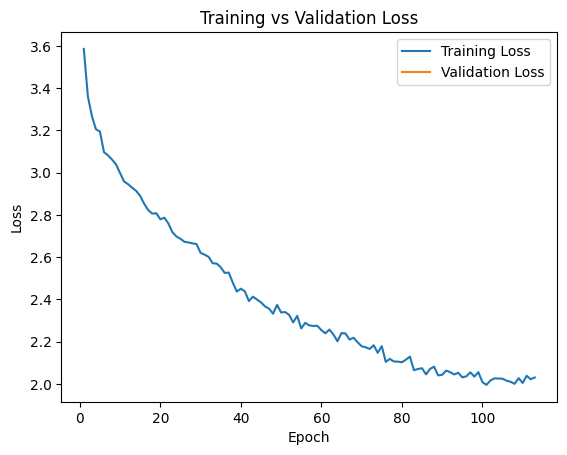

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
generated_outputs = []
for prompt in prompts:
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output = model.generate(input_ids, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)
    generated = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_outputs.append(generated)

# Compute cosine similarity
gen_embeddings = embedder.encode(generated_outputs, convert_to_tensor=True)
true_embeddings = embedder.encode(synopses, convert_to_tensor=True)

cosine_scores = util.cos_sim(gen_embeddings, true_embeddings)
avg_cosine_sim = torch.mean(torch.diagonal(cosine_scores)).item()
print(f"\nAverage Cosine Similarity: {avg_cosine_sim:.4f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati


Average Cosine Similarity: 0.2830
